In [14]:
# Installing libraries
#!pip install pandas
#!pip install numpy

In [120]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [176]:
#loading data + checking headers/info
data = pd.read_csv('IB96830815_Transacties_CSV_20250121_fromNOV_24.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3217 entries, 0 to 3216
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Boekdatum               3217 non-null   object
 1   Valutadatum             3217 non-null   object
 2   Rekening                3217 non-null   object
 3   Bedrag                  3217 non-null   object
 4   Valuta                  3217 non-null   object
 5   Wederpartij             3206 non-null   object
 6   Rekening wederpartij    3206 non-null   object
 7   Mededeling begunstigde  3175 non-null   object
dtypes: object(8)
memory usage: 201.2+ KB


In [178]:
data.head(5)

,Boekdatum,Valutadatum,Rekening,Bedrag,Valuta,Wederpartij,Rekening wederpartij,Mededeling begunstigde
0,01-11-2024,01-11-2024,Vindsubsidies B.V. 998-EUR,"3167,86",EUR,Veth Propulsion B.V.,NL47 INGB 0006 6182 60,VF22V1-14196
1,01-11-2024,01-11-2024,Vindsubsidies B.V. 998-EUR,"4374,55",EUR,Ilge Subscription Management B.V.,NL32 INGB 0007 1653 19,VF22VI-10584
2,01-11-2024,01-11-2024,Vindsubsidies B.V. 998-EUR,"868,74",EUR,BATIVO BV,NL72 INGB 0652 0295 23,Factuur:382
3,01-11-2024,01-11-2024,Vindsubsidies B.V. 998-EUR,"542,02",EUR,BATIVO BV,NL72 INGB 0652 0295 23,Factuur:383
4,01-11-2024,01-11-2024,Vindsubsidies B.V. 998-EUR,"317,44",EUR,CLICKVIN BV,NL49 ABNA 0407 1886 06,VF22V1-13777


In [180]:
data.describe()

,Boekdatum,Valutadatum,Rekening,Bedrag,Valuta,Wederpartij,Rekening wederpartij,Mededeling begunstigde
count,3217,3217,3217,3217,3217,3206,3206,3175
unique,75,75,1,1985,1,1433,1396,3145
top,27-11-2024,27-11-2024,Vindsubsidies B.V. 998-EUR,"4537,50",EUR,Provincie Overijssel,NL45 RABO 0397 3411 21,Factuur:383
freq,204,204,3217,32,3217,24,24,4


In [182]:
print('Columns in the dataset:', data.columns)

Columns in the dataset: Index(['Boekdatum', 'Valutadatum', 'Rekening', 'Bedrag', 'Valuta',
       'Wederpartij', 'Rekening wederpartij', 'Mededeling begunstigde'],
      dtype='object')


In [184]:
#Data checking for debugging:
print(data['Bedrag'].head(20)) #checking 20 rows for data-setup

0     3167,86
1     4374,55
2      868,74
3      542,02
4      317,44
5      317,44
6     6384,78
7     2361,63
8      214,90
9       31,58
10      31,58
11     214,90
12    3048,47
13    1598,71
14    1598,71
15    2406,69
16     693,17
17    1160,66
18    1405,54
19     985,67
Name: Bedrag, dtype: object


In [186]:
#Preparing: parsing dates and sorting/aggregate
data['Valutadatum'] = pd.to_datetime(data['Valutadatum'], format='%d-%m-%Y')

In [188]:
#Checking NaN-Values:
print(data[data['Bedrag'].isna()])

Empty DataFrame
Columns: [Boekdatum, Valutadatum, Rekening, Bedrag, Valuta, Wederpartij, Rekening wederpartij, Mededeling begunstigde]
Index: []


In [190]:
#Cleaning column Bedrag
data['Bedrag'] = data['Bedrag'].astype(str).str.replace(',', '.').str.replace(r'[^0-9.-]', '', regex=True)
data['Bedrag'] = pd.to_numeric(data['Bedrag'], errors='coerce')
if data['Bedrag'].isna().any():
    raise ValueError("Some values in 'Bedrag' could not be converted to numeric. Please inspect these rows.")
data = data.dropna(subset=['Valutadatum', 'Bedrag']) #dropping rows with NaN values in valutadatum or bedrag
data = data.sort_values('Valutadatum')


In [192]:
#Aggregate weekly cashflow
data.set_index('Valutadatum', inplace=True)
weekly_data = data['Bedrag'].resample('W').sum()

#checking weekly_data:
print(weekly_data.head(10))

Valutadatum
2024-11-03      52910.03
2024-11-10     -42319.85
2024-11-17     456560.84
2024-11-24     415538.86
2024-12-01    -481094.65
2024-12-08     -78130.19
2024-12-15     337882.54
2024-12-22     493176.02
2024-12-29     380910.63
2025-01-05   -1142731.73
Freq: W-SUN, Name: Bedrag, dtype: float64


In [194]:
#scaling and converting
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(weekly_data.values.reshape(-1, 1))

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

In [196]:
# setting weeks looking back
sequence_length = 10  
X, y = create_sequences(scaled_data, sequence_length)

In [198]:
#splitting into test/training
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [200]:
#setting up the model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [202]:
#Training
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.5416 - val_loss: 0.9456
Epoch 2/50
1/1 [==============================] - 0s 96ms/step - loss: 0.5195 - val_loss: 0.9135
Epoch 3/50
1/1 [==============================] - 0s 104ms/step - loss: 0.4956 - val_loss: 0.8826
Epoch 4/50
1/1 [==============================] - 0s 91ms/step - loss: 0.4727 - val_loss: 0.8519
Epoch 5/50
1/1 [==============================] - 0s 128ms/step - loss: 0.4499 - val_loss: 0.8206
Epoch 6/50
1/1 [==============================] - 0s 87ms/step - loss: 0.4272 - val_loss: 0.7883
Epoch 7/50
1/1 [==============================] - 0s 93ms/step - loss: 0.4038 - val_loss: 0.7564
Epoch 8/50
1/1 [==============================] - 0s 74ms/step - loss: 0.3807 - val_loss: 0.7230
Epoch 9/50
1/1 [==============================] - 0s 97ms/step - loss: 0.3570 - val_loss: 0.6874
Epoch 10/50
1/1 [==============================] - 0s 78ms/step - loss: 0.3321 - val_loss: 0.6493
Epoch 11/50
1/1 [============

In [204]:
#Setting up predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test)

1/1 [==============================] - 0s 320ms/step


In [206]:
#Prediction next 10 weeks
future_predictions = []
current_sequence = X_test[-1]  # Start from the last sequence in the test set

for _ in range(10):  # Predict for 10 weeks
    next_pred = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
    future_predictions.append(next_pred)
    # Update the sequence with the predicted value
    current_sequence = np.append(current_sequence[1:], next_pred).reshape(-1, 1)

# Rescale future predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 [==============================] - 0s 18ms/step


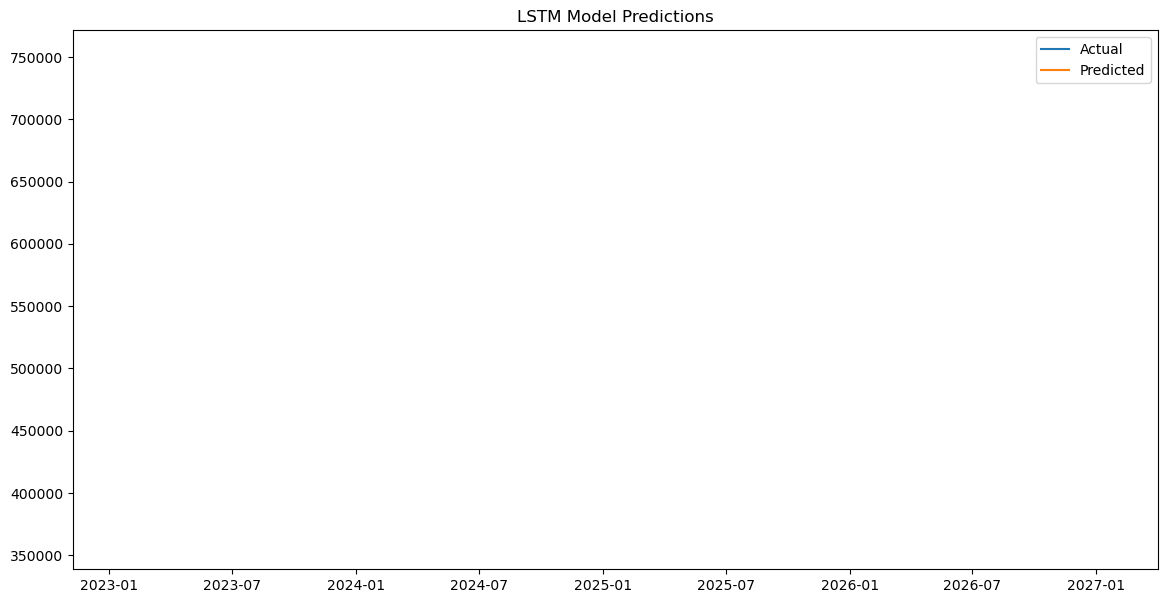

In [210]:
#plotting results
plt.figure(figsize=(14, 7))
plt.plot(weekly_data.index[-len(y_test):], scaler.inverse_transform(y_test), label='Actual')
plt.plot(weekly_data.index[-len(y_test):], predictions, label='Predicted')
plt.title('LSTM Model Predictions')
plt.legend()
plt.show()


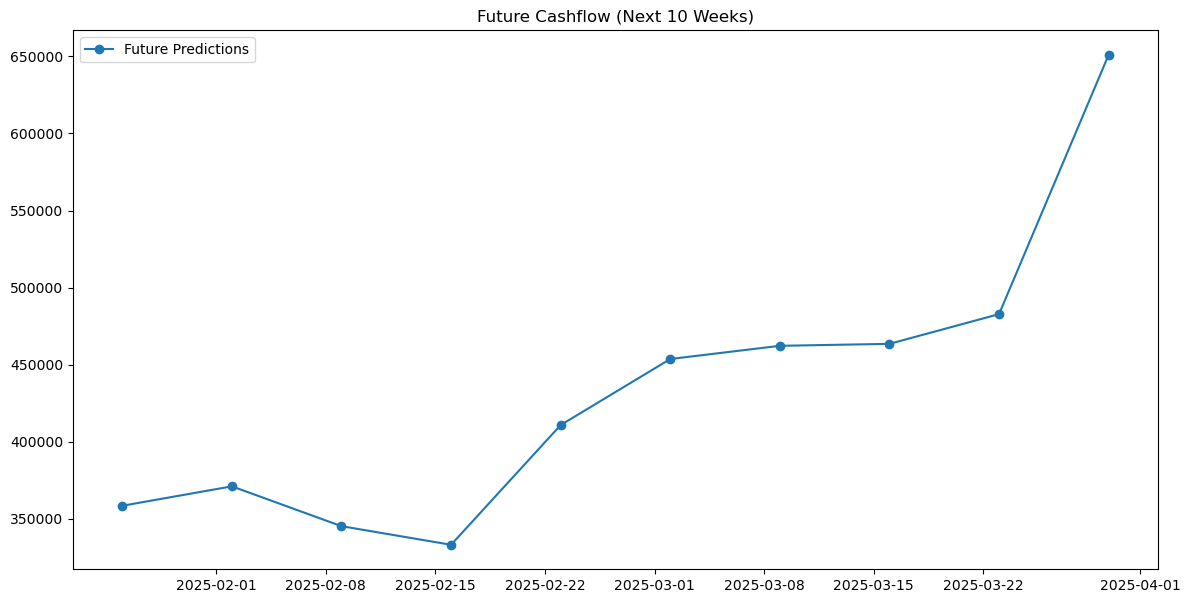

In [212]:
#Plotting future cashflow
future_dates = pd.date_range(start=weekly_data.index[-1], periods=11, freq='W')[1:]
plt.figure(figsize=(14, 7))
plt.plot(future_dates, future_predictions, marker='o', label='Future Predictions')
plt.title('Future Cashflow (Next 10 Weeks)')
plt.legend()
plt.show()

MODEL FITTING CHECKS

In [215]:
#Check overfitting/underfitting
#importing packages
from sklearn.metrics import mean_squared_error

In [217]:
#RSME as indicator for performance, calculating RSME
test_rmse = np.sqrt(mean_squared_error(actual, predictions))
print(f"Test RMSE: {test_rmse:.2f}")

Test RMSE: 393414.79


In [219]:
#training set predictions:
train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions)
train_actual = scaler.inverse_transform(y_train)

train_rmse = np.sqrt(mean_squared_error(train_actual, train_predictions))
print(f"Train RMSE: {train_rmse:.2f}")

1/1 [==============================] - 0s 18ms/step
Train RMSE: 90197.94


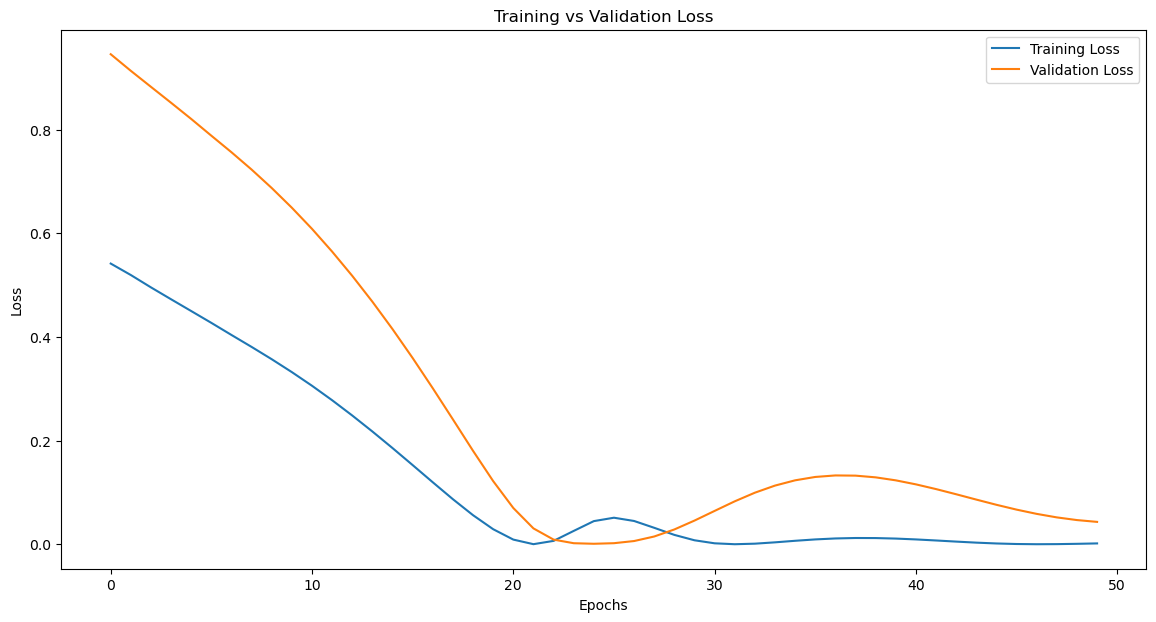

In [221]:
#Plotting training data vs validation loss:
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

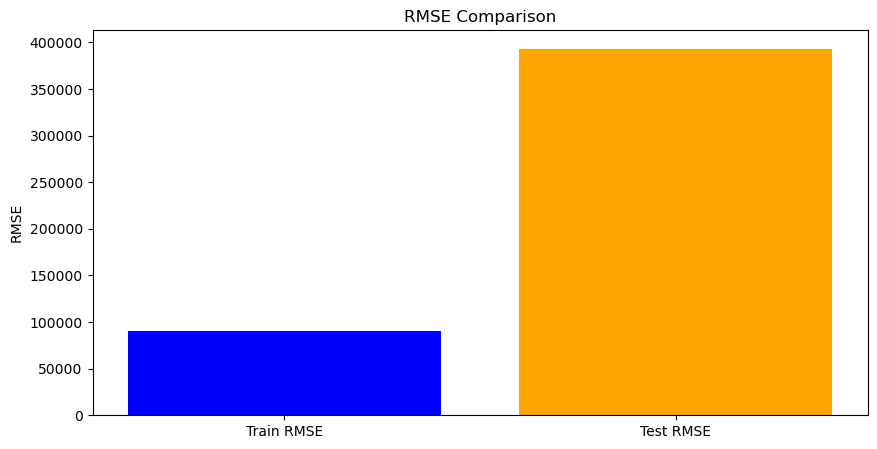

In [223]:
#RSME comparison
labels = ['Train RMSE', 'Test RMSE']
values = [train_rmse, test_rmse]
plt.figure(figsize=(10, 5))
plt.bar(labels, values, color=['blue', 'orange'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.show()